In [143]:
import sys
sys.path.append("../../../RWKV-LM/RWKV-v4neo") # go to parent dir

In [138]:
from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
import torch

### A little AFT implementation

Going to use these as test variables. 

In [749]:
#T/B/C
k=torch.randn((12,4,128))
v=torch.randn((12,4,128))
w=torch.randn((12,12))

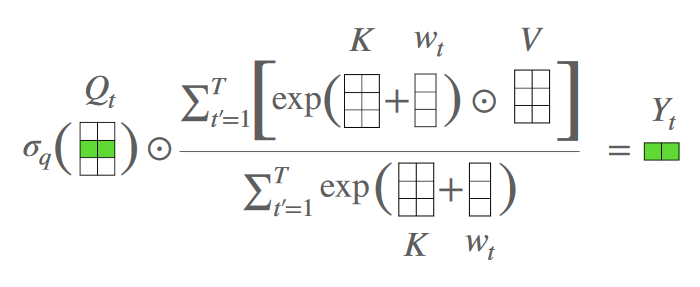

where T=3 d=2

$$Y_t=\sigma_q(Q_t)\odot\frac{\sum_{t'=1}^{T}e^{K_{t'}+w_{t,t'}}\odot V_{t'}}
{\sum_{t'=1}^{T}e^{K_{t'}+w_{t,t'}}}$$

Compare to MHA:

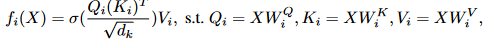

Mostly grabbed from: https://nn.labml.ai/transformers/aft/index.html

In [750]:
class myWKV(nn.Module):
    def forward(self, k,v,w):
        seq_len=k.shape[0]
        #autoregressive mask
        mask = torch.ones(seq_len, seq_len, dtype=torch.bool)
        mask = torch.tril(local_mask)
        w=(w*mask)[...,None]
        #so e^k != inf,done on top and bottum so cancels out, similar patern with RWKV-LM
        mk = k.max(dim=0, keepdims=True)[0] 
        mw = w.max(dim=1,  keepdims=True)[0]
        exp_k = torch.exp(k - mk)
        exp_w = torch.exp(w - mw)
        num = torch.einsum('ijb,jbd->ibd', exp_w, exp_k * v)
        den = torch.einsum('ijb,jbd->ibd', exp_w, exp_k)
        return num / den

Note: Ah, this is why it doesn't perform well in fp16. 

In [751]:
myWKV()(k,v,w)

tensor([[[-0.1984, -0.3639,  0.0749,  ..., -0.8137, -0.4191,  0.7493],
         [ 0.0834, -0.0965, -1.2330,  ...,  0.1922, -0.4651, -0.0541],
         [-0.2388, -0.1689, -0.4599,  ..., -0.4491, -0.0932, -0.3836],
         [ 0.7507,  0.5208,  0.6988,  ..., -0.9262, -0.1379,  0.3002]],

        [[-0.1376, -0.2457,  0.0689,  ..., -0.8245, -0.4090,  0.7465],
         [ 0.0761, -0.1533, -1.2438,  ...,  0.2762, -0.6847, -0.2283],
         [-0.2442, -0.1828, -0.4701,  ..., -0.4536, -0.1538, -0.3452],
         [ 0.5156,  0.2388,  0.7318,  ..., -0.7636,  0.0199,  0.3532]],

        [[-0.0973, -0.4237,  0.0517,  ..., -0.8167, -0.4142,  0.7555],
         [ 0.0295, -0.1445, -1.0423,  ...,  0.2562, -0.5001, -0.1575],
         [-0.0052, -0.1773, -0.4965,  ..., -0.4838,  0.2261, -0.4163],
         [ 0.5781,  0.3773,  0.7839,  ..., -0.8568, -0.0438,  0.0991]],

        ...,

        [[-0.2455, -0.4550,  0.0353,  ..., -0.6019, -0.4619,  0.7026],
         [ 0.3597, -0.0138, -1.0167,  ...,  0.2118, -1.20

$w_{t,t'}$ is actually parameterized as two matrices, included for completeness. $d'$ is some small dimension such as 128. 

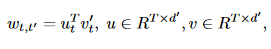

### Unable to get RWKV to work. 

In [637]:
import os
os.environ["RWKV_JIT_ON"]="1"
#context length
os.environ["RWKV_T_MAX"]="1024"
os.environ["RWKV_FLOAT_MODE"]="32"
from src.model import WKV,RWKV

In [203]:
from fastai.torch_core import no_random

In [753]:
from dataclasses import dataclass

@dataclass
class RWKVArgs:
    n_embd=512
    dim_att=512
    dim_ffn =512*4
    tiny_att_layer=-999
    tiny_att_dim=0
    vocab_size=1024
    n_layer=2
    my_pos_emb=0
    pre_ffn=0
    ctx_len=1024
    head_qk=0
    grad_cp=0

In [754]:
rwkv=RWKV(RWKVArgs())

I was never able to really get this to work.

In [757]:
#/home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py:48
import pdb;pdb.set_trace()
rwkv((torch.rand(4,12)*500).int())

--Return--
None
> /tmp/ipykernel_166725/2239332302.py(2)<module>()
      1 #/home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py:48
----> 2 import pdb;pdb.set_trace()
      3 rwkv((torch.rand(4,12)*500).int())

ipdb> b /home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py:65
Breakpoint 8 at /home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py:65
ipdb> c
    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

> /home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py(48)forward()
     46     @staticmethod
     47     def forward(ctx, B, T, C, w, u, k, v):
7--> 48         ctx.B = B
     49         ctx.T = T
     50         ctx.C = C

ipdb> n
> /home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py(49)forward()
     47     def forward(ctx, B, T, C, w, u, k, v):
7    48         ctx.B = B
---> 49         ctx.T = T
     50         ctx.C = C
     51         assert T <= T_MAX

ipdb> 
> /home/molly/Projects/RWKV-LM/RWKV-v4

ipdb> 
> /home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py(56)forward()
     54             w = -torch.exp(w.contiguous())
     55             u = u.contiguous()
---> 56             k = k.contiguous()
     57             v = v.contiguous()
     58         else:

ipdb> 
> /home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py(57)forward()
     55             u = u.contiguous()
     56             k = k.contiguous()
---> 57             v = v.contiguous()
     58         else:
     59             w = -torch.exp(w.float().contiguous())

ipdb> 
> /home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py(63)forward()
     61             k = k.float().contiguous()
     62             v = v.float().contiguous()
---> 63         ctx.save_for_backward(w, u, k, v)
     64         y = torch.empty((B, T, C), device=w.device, memory_format=torch.contiguous_format)
8    65         wkv_cuda.forward(B, T, C, w, u, k, v, y)

ipdb> 
> /home/molly/Projects/RWKV-LM/RWKV-v4neo/src/model.py(64)forward()
     62  

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


tensor([[[-1.5021e-01, -2.6783e-01,  2.2632e-01,  ...,  1.9564e-01,
           1.7399e-01, -3.0616e-01],
         [ 7.0133e-01, -1.1337e+00,  8.8988e-02,  ..., -4.8882e-01,
          -1.8693e-01, -2.9955e-01],
         [ 6.8350e-01,  6.5257e-01, -6.9395e-01,  ...,  9.0460e-02,
          -9.3621e-02,  1.6127e-01],
         ...,
         [-2.3905e-01,  1.6333e+00,  4.4925e-01,  ..., -1.1607e+00,
           4.0535e-01,  6.1056e-01],
         [-2.0414e-01, -1.2620e-01,  1.5862e-01,  ...,  5.5861e-01,
          -2.6061e-02,  1.6887e-01],
         [-3.0302e-01, -1.4906e-01,  4.3915e-02,  ..., -5.8636e-01,
           5.2918e-02,  6.0283e-02]],

        [[-5.7804e-01,  2.1120e-01,  8.0944e-01,  ..., -4.0066e-01,
           2.7452e-01,  4.3738e-01],
         [-8.8068e-01, -2.9746e-01,  3.4179e-02,  ..., -5.6644e-02,
           5.4487e-01,  1.8037e+00],
         [-1.7817e-01,  1.3507e-01,  5.7038e-02,  ..., -1.0114e+00,
           3.5425e-01, -3.0171e-01],
         ...,
         [-3.4249e-01, -1

### Looking at some formulas. 

A image based representation of AFT, where T=3 d=2.(https://arxiv.org/pdf/2105.14103.pdf)

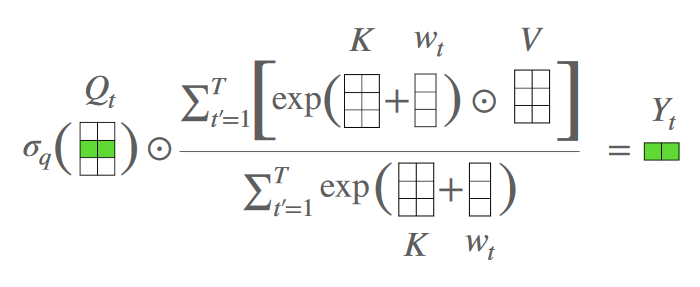

And now more mathy

$$Y_t=\sigma_q(Q_t)\odot\frac{\sum_{t'=1}^{T}e^{K_{t'}+w_{t,t'}}\odot V_{t'}}
{\sum_{t'=1}^{T}e^{K_{t'}+w_{t,t'}}}$$

Good to compare to RWKV notation now

$$O_i=\sigma(R_i)\frac{\sum_{j=1}^{T}e^{K_{j}+W_{i-j}} V_{j}}
{\sum_{j=1}^{T}e^{K_{j}+W_{j}}}$$

Most stays the same. W changes and has some concept of "time-weighting" instead. The RWKV author introduced this, but I do not know why. A bit of the explanations of tricks can be found here: https://github.com/BlinkDL/minGPT-tuned

I don't think there is a difference between Q and R. They seem to be just renamed. 

### Making everything look recursive. 

Next, RNNs are autoregressive, so we absorb the autoregressive mask into the equation. Since the mask would make everything above i zero, we only sum to i. 

$$O_i=\sigma(R_i)\frac{\sum_{j=1}^{i}e^{K_{j}+W_{i-j}} V_{j}}
{\sum_{j=1}^{i}e^{K_{j}+W_{j}}}$$

Okay, we could stop here and train, we want to make this fast. The authors introduce a recursive formula for this. 

$O_1=\sigma(R_1)\frac{e^{W_0+K_1}V_1}{e^{W_0+K_1}}=\sigma(R_1)V_1$

$O_2=\sigma(R_2)\frac{e^{W_1+K_1}V_1+e^{W_0+K_2}V_2}{e^{W_1+K_1}+e^{W_0+K_2}}$

$O_3=\sigma(R_3)\frac{e^{W_2+K_1}V_1+e^{W_1+K_2}V_2+e^{W_0+K_3}V_3}{e^{W_2+K_1}+e^{W_1+K_2}+e^{W_0+K_3}}$

$O_4=\sigma(R_4)\frac{e^{W_3+K_1}V_1+e^{W_2+K_2}V_2+e^{W_1+K_3}V_3+e^{W_0+K_4}V_4}{e^{W_3+K_1}+e^{W_2+K_2}+e^{W_1+K_3}+e^{W_0+K_4}}$

RWKV now defines $W_0=u$, and $W_{n\geq1}=(n-1)w$, eliminating many $W_n$. $u$ and $w$ are vectors of the embedding size. 

$O_4=\sigma(R_4)\frac{e^{2w+K_1}V_1+e^{w+K_2}V_2+e^{K_3}V_3+e^{u+K_4}V_4}{e^{2w+K_1}+e^{w+K_2}+e^{K_3}+e^{u+K_4}}$

So, the number of operation in parameters in "attention" have decreased again. 

### This big long RNN formula

Okay lets make the RNN formula. I will try to sumarize this, instead of going through it. First we set some variables. Taken from: https://github.com/BlinkDL/RWKV-LM/blob/main/RWKV-v4neo/cuda/wkv_cuda.cu

$p=0,q=0,o=-1e38$

This is our goal, taken from the math above. We want Y_1=O_1

Note: first '=' is an assignment, following are for showing equality. 

$O_1=\frac{e^{W_0+K_1}V_1}{e^{W_0+K_1}}=V_1$

$no=max(o,u+K_1)=max(-1e38,u+K_1)=u+K_1$

$A_1 =e^{o - no}=e^{-1e38 - no}=0$

$B_1=e^{u+K_1-no}=e^{u+K_1-(u+K_1)}=1$

$Y_1=\frac{A_1p+B_1V_1}{A_1q+B_1}=\frac{0+1V_1}{0+1}=V_1$

$no = max(w + o, K_1)=max(w - 1e38, K_1)=K_1$

$A_1 = e^{w + o - no}=e^{w - 1e38 - no}=0$

$B_1 = e^{K_1 - no}=e^{K_1 - (K_1)}=1$

$p = A_1p + B_1V_1 = (0)p + (1)V_1 = V_1$

$q = A_1q + B_1=(0)q + (1)=1$

$o = no = K_1$

That is the end of the first iteration, here is our second goal. 

$O_2=\frac{e^{W_1+K_1}V_1+e^{W_0+K_2}V_2}{e^{W_1+K_1}+e^{W_0+K_2}}=\frac{e^{K_1}V_1+e^{u+K_2}V_2}{e^{K_1}+e^{u+K_2}}$

$no=max(o,u+K_2)=max(K_1,u+K_2)$

$A_2 = e^{o-no}$

$B_2 = e^{u+K_2-no}$

From here on $e^{-no}$ can just be factored out on top and bottom for $Y_t$. 

$Y_2=\frac{A_2p+B_2V_2}{A_2q+B_2}=\frac{e^{K_1-no}(V_1)+e^{u+K_2-no}V_2}{e^{K_1-no}(1)+e^{u+K_2-no}}=\frac{e^{K_1}(V_1)+e^{u+K_2}V_2}{e^{K_1}(1)+e^{u+K_2}}$

$no = max(w + o, K_2)=max(w + K_1, K_2)$

$A_2 = e^{w + o - no}=e^{w + K_1 - no}$

$B_2 = e^{K_2- no}$

$p = A_2 p + B_2V_2=e^{w + K_1 - no} V_1+e^{K_2- no}V_2$

$q = A_2q+B_2=e^{w + K_1 - no}(1)+e^{K_2- no}$

$o=no=max(w + K_1, K_2)$

### W reduction

We are getting rid of a lot of the parameters of w here, wouldn't that make the model perform worse? Well the authors of AFT actually introduced a version that completely removed W called AFT-Simple, so I think the performance of that model will act like our lower bound.  https://arxiv.org/pdf/2105.14103.pdf

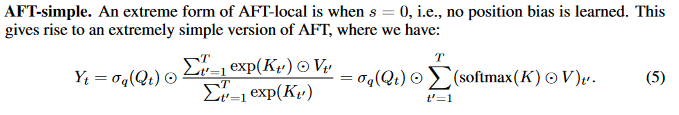

### AFT Results

L, d, h, T denote number of blocks (depth), dimension of features, number of
heads, and sequence length, respectively. Enwik8

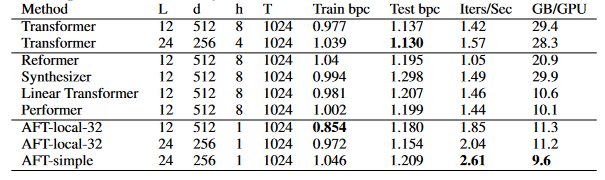

AFT also has results for image classification and image autoregressive modeling. 

### RWKV-LM Results

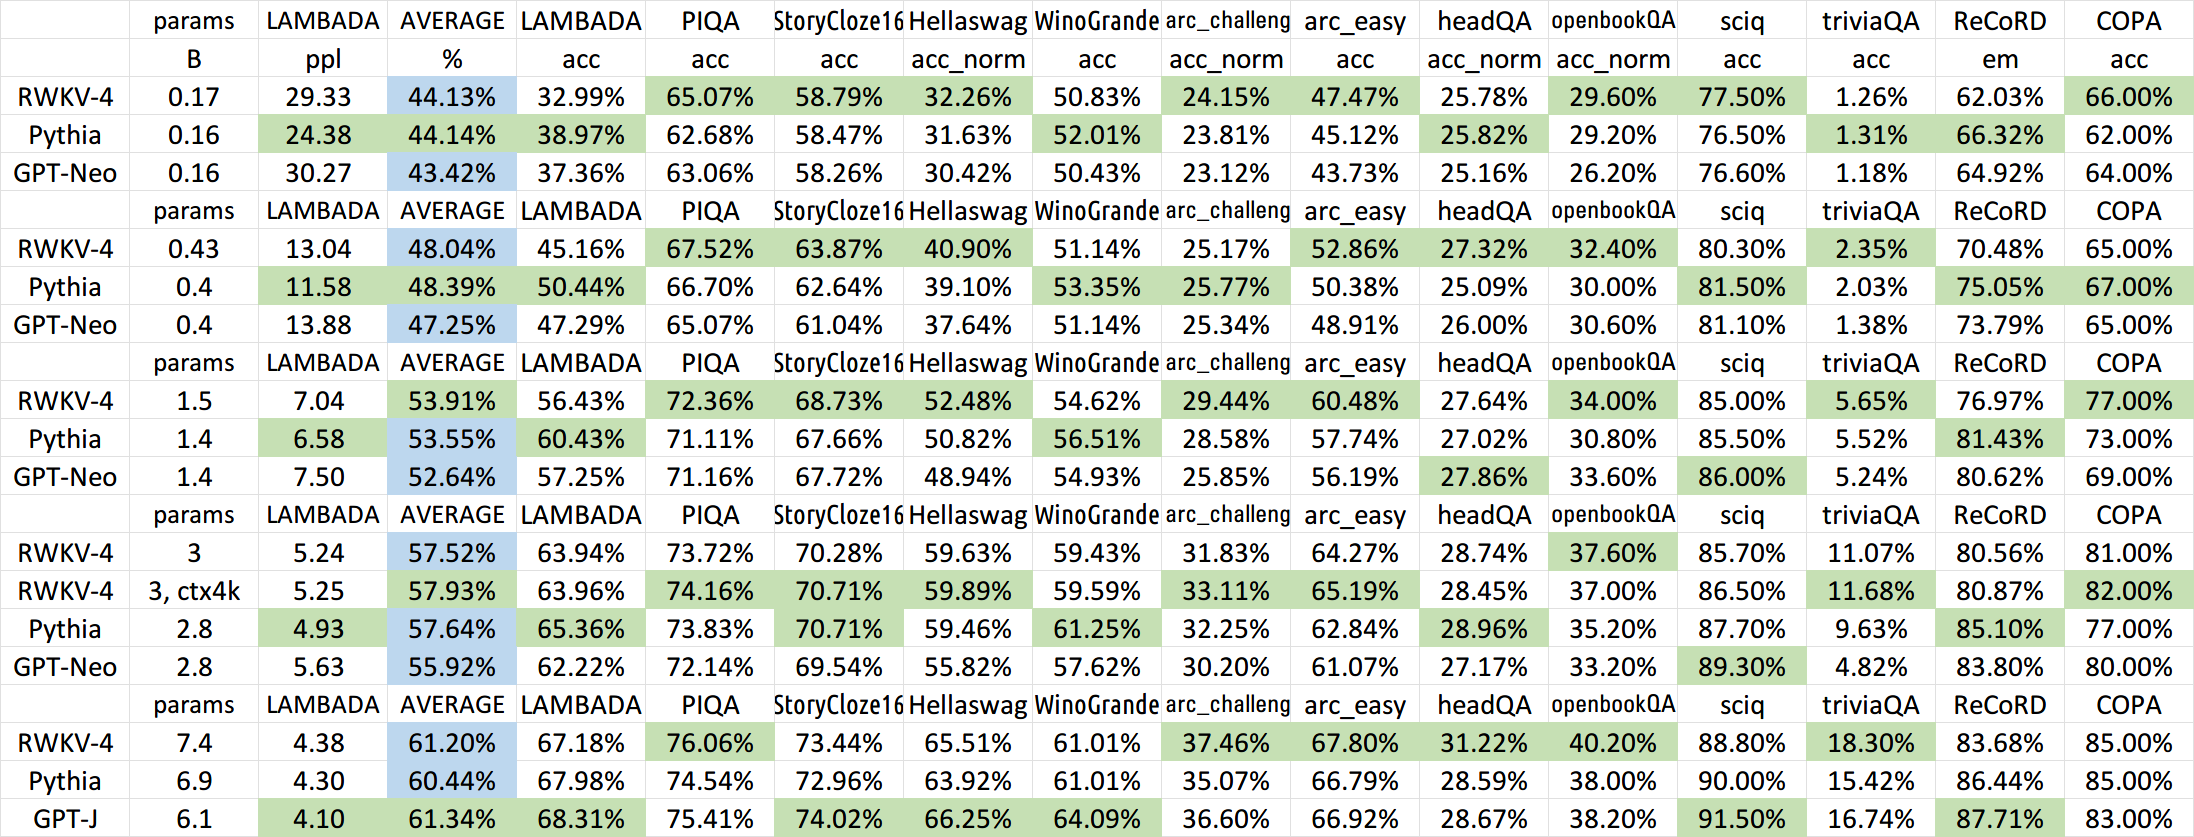